In [13]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F, types as T

In [10]:
spark = SparkSession.builder.getOrCreate()

pandas is the dominant
in-memory Python data manipulation library, while PySpark is the dominantly
distributed one. Combining both of them unlocks additional possibilities.

Connectors to data storage and processing solutions:
* Install and configure the connector (if necessary)
* Customize the SparkReader
* Read the data

In [11]:
path = "/".join("\sparkdata\DataAnalysisWithPythonAndPySpark-Data\gsod_noaa".split("\\"))

In [12]:
from functools import reduce
gsod = (
    reduce(
        lambda x, y: x.unionByName(y, allowMissingColumns=True),
        [
            spark.read.parquet(path+f"/gsod{year}.parquet")
            for year in range(2010, 2021)
        ],
    )
    .dropna(subset=["year", "mo", "da", "temp"])
    .where(F.col("temp") != 9999.9)
    .drop("date")
)

# Column transformations with pandas: Series UDF

## Series to Series UDF

They work like Python UDFs, with the difference being that Python UDFs work on each record at a time, while scalar UDFs work on one Series at a time.

In a Python UDF, when you pass column objects to your UDF, PySpark will unpack
each value, perform the computation, and then return the value for each record in
a Column object.

In a Scalar UDF, PySpark will serialize
(through a library called PyArrow)
each partitioned column into a pandas Series object (http://mng.bz/g41l).
You then perform the operations on the Series object directly, returning a Series of
the same dimension from your UDF.

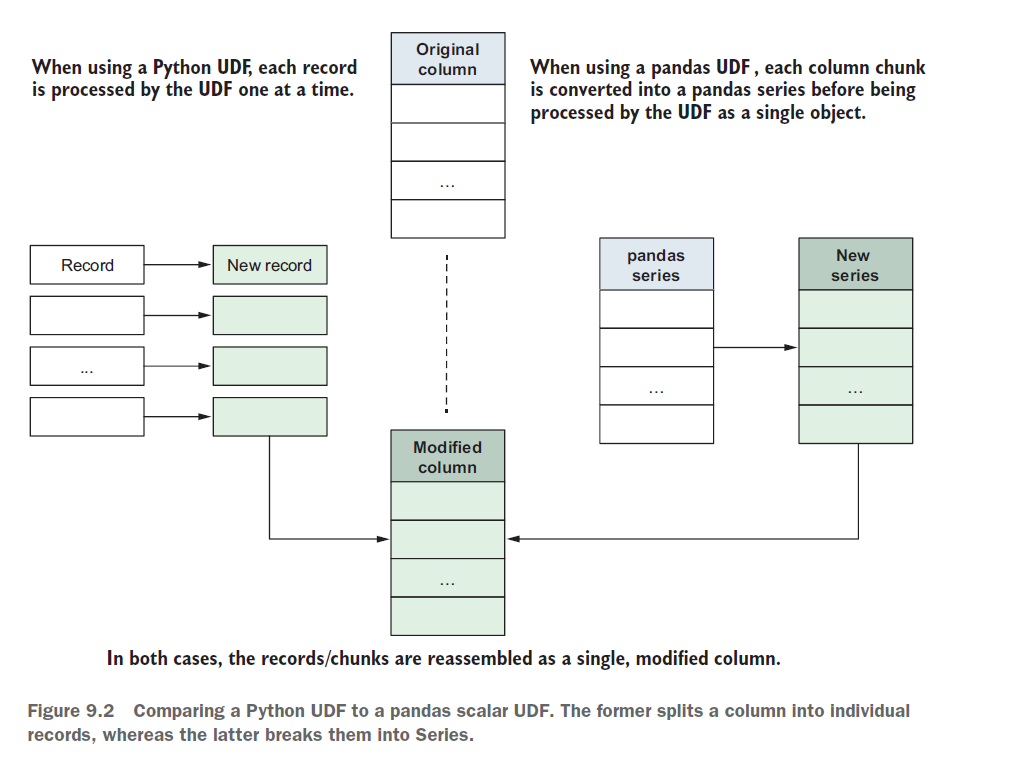

In [8]:
import pandas as pd

@F.pandas_udf(T.DoubleType())
def f_to_c(degrees: pd.Series) -> pd.Series:
    """Transforms Farhenheit to Celcius."""
    return (degrees - 32) * 5 / 9

In [9]:
gsod = gsod.withColumn("temp_c", f_to_c(F.col("temp")))
gsod.select("temp", "temp_c").distinct().show(5)

+----+-------------------+
|temp|             temp_c|
+----+-------------------+
|29.6|-1.3333333333333326|
|37.2| 2.8888888888888906|
|53.5| 11.944444444444445|
|70.4| 21.333333333333336|
|24.7| -4.055555555555555|
+----+-------------------+
only showing top 5 rows



Useful when the record-wise transformation we want to apply to our data frame is not available in the stock of PySpark functions.

## Iterator of Series UDF
Useful when we have a _expensive cold start_(operation needed to be performed once at the beggining of the processing step) operation we need to perform, for example, deserializing a local ML model

differences to Series to Series UDF:
* The signature goes from (pd.Series) -> pd.Series to (Iterator[pd.Series]) -> 
* When working with the Series to Series UDF, we assumed that PySpark would give us one batch at a time. Here, since we are working with an Iterator of Series, we are explicitly iterating over each batch one by one. PySpark will distribute the work for us.Iterator[pd.Series].
* Rather than using a return value, we yield so that our function returns an iterator.


In [14]:
from time import sleep
from typing import Iterator

@F.pandas_udf(T.DoubleType())
def f_to_c2(degrees: Iterator[pd.Series]) -> Iterator[pd.Series]:
    """Transforms Farhenheit to Celcius."""
    sleep(5)
    for batch in degrees:
        yield (batch - 32) * 5 / 9

In [15]:
gsod.select(
    "temp", f_to_c2(F.col("temp")).alias("temp_c")
).distinct().show(5)

+----+-------------------+
|temp|             temp_c|
+----+-------------------+
|29.6|-1.3333333333333326|
|37.2| 2.8888888888888906|
|53.5| 11.944444444444445|
|70.4| 21.333333333333336|
|24.7| -4.055555555555555|
+----+-------------------+
only showing top 5 rows



## Iterator of multiple Series to Iterator of Series

wrap multiple columns in a single iterator

In [29]:
from typing import Tuple

@F.pandas_udf(T.DateType())
def create_date(year_mo_da: Iterator[Tuple[pd.Series, pd.Series, pd.Series]]) -> Iterator[pd.Series]:
    
    for year, mo, da in year_mo_da:
        yield pd.to_datetime(
            pd.DataFrame(dict(year=year, month=mo, day=da))
        )
        

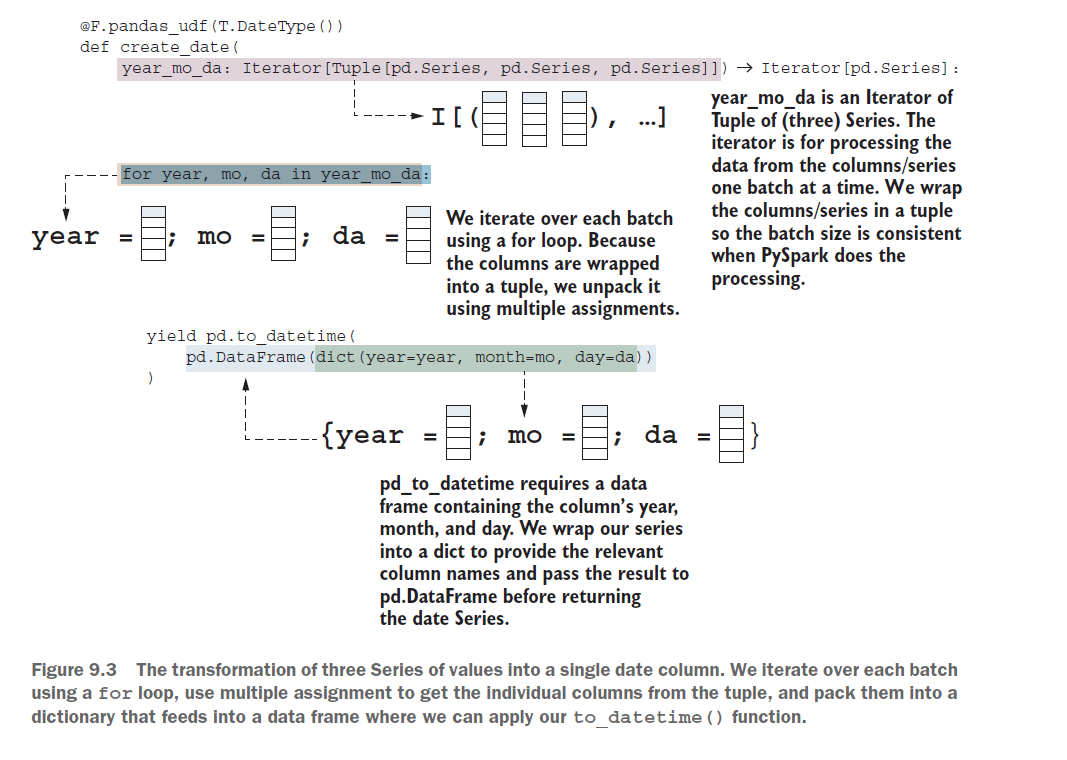

In [30]:
gsod.select(
    "year", "mo", "da",
    create_date(F.col("year"), F.col("mo"), F.col("da")).alias("date"),
).distinct().show(5)

+----+---+---+----------+
|year| mo| da|      date|
+----+---+---+----------+
|2010| 08| 31|2010-08-31|
|2010| 12| 20|2010-12-20|
|2010| 12| 16|2010-12-16|
|2010| 04| 03|2010-04-03|
|2010| 03| 17|2010-03-17|
+----+---+---+----------+
only showing top 5 rows



Note: By default, Spark will aim for 10,000 records per batch. You can customize
the maximum size of each batch using the spark.sql.execution.arrow.maxRecordsPerBatch config when creating the SparkSession object; 10,000
records is a good balance for most jobs. If you are working with memorystarved
executors, you might want to reduce this.

# UDFs on grouped data: Aggregate and apply

When we need to worry about the composition of the batches.

* Group aggregate UDFs: You need to perform aggregate functions such as count()or sum()
* Group map UDFs: Your data frame can be split into batches based on the values DataFrame before combining each batch back into a Spark data frame. For instance, we could have our gsod data batched by station month and perform operations on the resulting data frames.

They are the answer to the split-apply-combine pattern

* split the data set into logical batches (using groupby())
* apply a function to each batch independently
* combine the batches into a unified data set

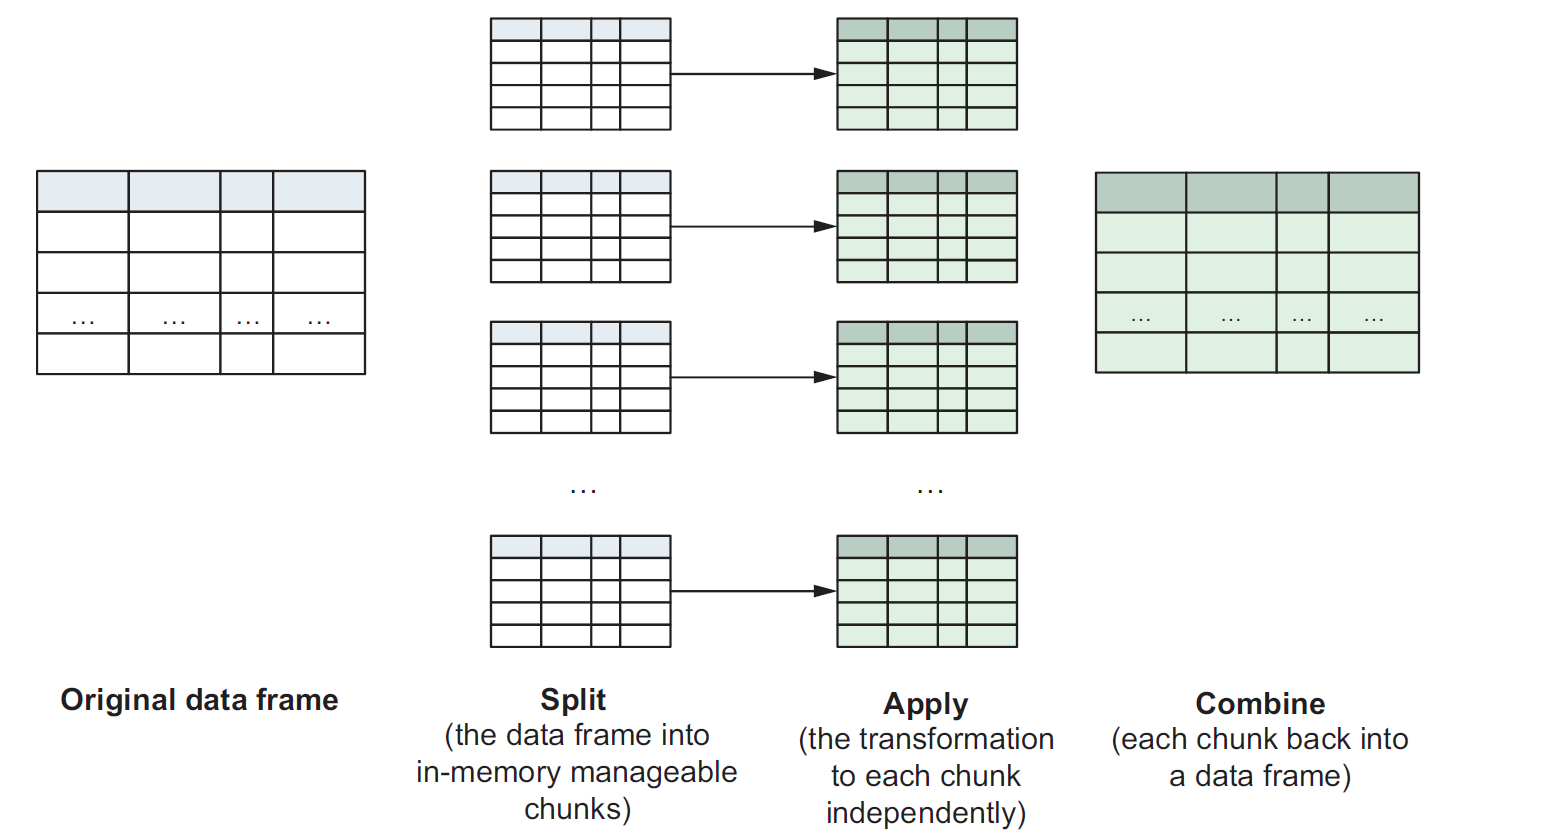

## Group aggregate UDFs


A group aggregate UDF is simply a custom aggregate function we pass as an argument to agg().

In [9]:
from sklearn.linear_model import LinearRegression
import pandas as pd

@F.pandas_udf(T.DoubleType())
def rate_of_change_temperature(day: pd.Series, temp: pd.Series) -> float:
    """Returns the slope of the daily temperature for a given period of time."""
    return (
        LinearRegression()
        .fit(X=day.astype(int).values.reshape(-1, 1), y=temp)
        .coef_[0]
    )

In [10]:
result = gsod.groupby("stn", "year", "mo").agg(
    rate_of_change_temperature(gsod["da"], gsod["temp"]).alias(
        "rt_chg_temp"
    )
)
result.show(5, False)

+------+----+---+-------------------+
|stn   |year|mo |rt_chg_temp        |
+------+----+---+-------------------+
|007032|2013|01 |-0.2795031055900618|
|008268|2010|07 |-2.1999999999999877|
|008400|2010|02 |1.7828571428571436 |
|008400|2010|08 |0.8514508067970873 |
|008401|2011|03 |0.7514516129032257 |
+------+----+---+-------------------+
only showing top 5 rows



## Group map UDF

Rather than giving back a scalar as a result of a batch like the  aggregate UDF, grouped map UDF maps over a batch and returns a  pandas data frame that is then combined into a single Spark data frame.
Scalar UDFs relies on pandas Series, while group map relies on pandas DataFrame.

In [11]:
def scale_temperature(temp_by_day: pd.DataFrame) -> pd.DataFrame: ## no need for pandas_udf decorator
    """Returns a simple normalization of the temperature for a site.
    
    If the temperature is constant for the whole window, defaults to 0.5."""
    temp = temp_by_day.temp
    answer = temp_by_day[["stn", "year", "mo", "da", "temp"]]
    if temp.min() == temp.max():
        return answer.assign(temp_norm=0.5)
    return answer.assign(
        temp_norm=(temp - temp.min()) / (temp.max() - temp.min())
    )

In [12]:
gsod_map = gsod.groupby("stn", "year", "mo").applyInPandas(
    scale_temperature,
    schema=(
        "stn string, year string, mo string, "
        "da string, temp double, temp_norm double"
    ),
)

gsod_map.show(5, False)

+------+----+---+---+----+------------------+
|stn   |year|mo |da |temp|temp_norm         |
+------+----+---+---+----+------------------+
|008268|2010|07 |21 |89.6|1.0               |
|008268|2010|07 |22 |87.4|0.0               |
|008401|2011|11 |24 |61.3|0.52              |
|008401|2011|11 |05 |66.0|0.7080000000000001|
|008401|2011|11 |01 |68.2|0.7960000000000003|
+------+----+---+---+----+------------------+
only showing top 5 rows



# What to use, when

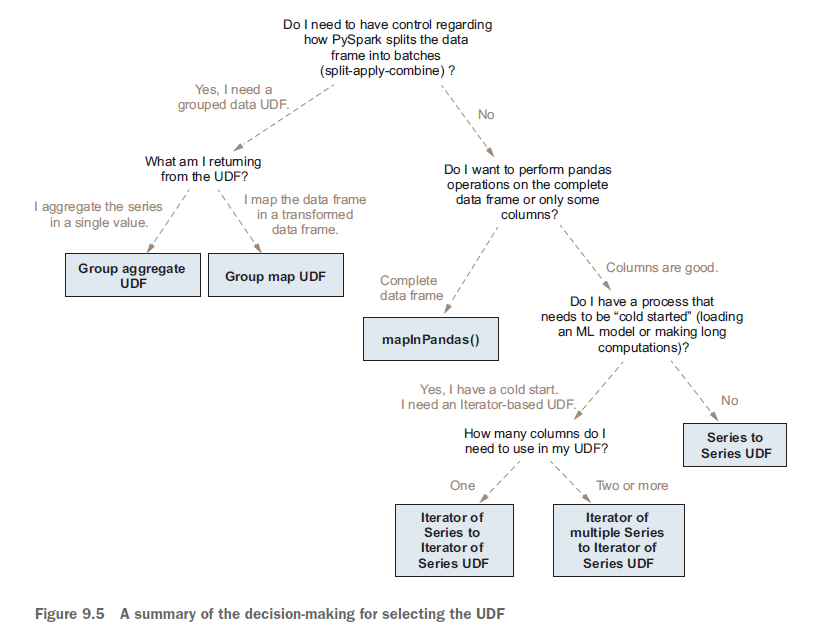

pandas UDFs are quite useful for extending PySpark with transformations that are not
included in the pyspark.sql module.

# Exercises

#### 1
Using the following definitions, create a temp_to_temp(value, from_temp, to_temp)
that takes a numerical value in from_temp degrees and converts it to to degrees. Use
a pandas UDF.
* C = (F - 32) * 5 / 9 (Celsius)
* K = C + 273.15 (Kelvin)
* R = F + 459.67 (Rankine)

In [15]:
import pandas as pd

def temp_to_temp(value:pd.Series,from_temp:str,to_temp:str) -> pd.Series:
    
    def from_c_to_f(value):
        return (value-32)*5/9
    
    def from_f_to_c(value):
        return (value*9)/5 + 32
    
    K = 273.15
    
    R = 459.67
    
    if from_temp == "K":
        value -= K
        from_temp = "C"
        
    if from_temp == "R":
        value -= R
        from_temp = "F"
    
    if from_temp== "C":
        if to_temp == "C":
            return value
        elif to_temp == "F":
            return from_c_to_f(value)
        elif to_temp == "K":
            return value + K
        else:
            return R - from_c_to_f(value)
    else:
        if to_temp == "C":
            return from_f_to_c(value)
        elif to_temp == "F":
            return value
        elif to_temp == "K":
            return from_f_to_c - K
        else:
            return R + value

#### 2
Modify the following code block to use Celsius degrees instead of Fahrenheit. How is
the result of the UDF different if applied to the same data frame?

In [ ]:
def scale_temperature(temp_by_day: pd.DataFrame) -> pd.DataFrame:
    """Returns a simple normalization of the temperature for a site.
    
    If the temperature is constant for the whole window, defaults to 0.5."""
    temp = temp_by_day.temp
    answer = temp_by_day[["stn", "year", "mo", "da", "temp"]]
    if temp.min() == temp.max():
        return answer.assign(temp_norm=0.5)
    return answer.assign(
        temp_norm=(temp - temp.min()) / (temp.max() - temp.min())
)

In [20]:
def scale_temperature(temp_by_day: pd.DataFrame) -> pd.DataFrame:
    """Returns a simple normalization of the temperature for a site.
    
    If the temperature is constant for the whole window, defaults to 0.5."""
    
    def f_to_c(temp):
        return (temp - 32.0) * 5.0 / 9.0
    
    temp = f_to_c(temp_by_day.temp)
    answer = temp_by_day[["stn", "year", "mo", "da", "temp"]]
    if temp.min() == temp.max():
        return answer.assign(temp_norm=0.5)
    return answer.assign(
        temp_norm=(temp - temp.min()) / (temp.max() - temp.min())
)